# simulation_dev 

TODO: 
* Push this to a new repo.
* Get rid of all parameters in the config file that aren't being used. Every one. 
* Make the printed output of the simulation.run neater and more informative. 
* Make a method in Simulation for visualizing tracks. 
* Document and organize the code you have so far. 
* Make this ipynb a "playground" to illustrate what is working so far, but not to develope. Or maybe make another ipynb for illustrating all that's working well. 
* Get at least a few sanity checks working for both the block level and simulation level tests. This is very important. 
* Get it all organized and looking good on github so you can easily show the team progress. 

In [1]:
%load_ext autoreload


In [2]:
%autoreload 2
import he6_cres_spec_sims.simulation_blocks as sim_blocks


In [3]:
config = sim_blocks.Config(config_filename = "config_example")

Reading the map_array from csv. 
filepath:  /home/drew/He6CRES/he6-cres-spec-sims/he6_cres_spec_sims/spec_tools/coil_classes/field_profile_pkl_files/main_field_0.689_trap_strength_0.001.csv
Time to initialize field_strength_interp =  0.008817911999999928 

Optimization terminated successfully.
         Current function value: -0.689350
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.6893498199715139


In [64]:
config_params.field_strength(0,0)

array(0.688311)

## Test physics

In [70]:
physics = sim_blocks.Physics(config)

In [71]:
print(physics.generate_beta_position_direction())
print(physics.generate_beta_energy())

([0.005191387839013739, 210.65879313307218, 0.00034111070411229835], [88.58739865316143, 310.53722095625153])
17800.0


## Test hardware

In [159]:
hardware = sim_blocks.Hardware(config)

In [169]:
hardware.generate_trapped_events_df()


 Event: 0/1...

Trapped!

 Event: 1/1...

Not Trapped: Pitch angle too small.
Not Trapped: Collided with guide wall.
Not Trapped: Pitch angle too small.
Not Trapped: Collided with guide wall.
Not Trapped: Collided with guide wall.
Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Not Trapped: Collided with guide wall.
Not Trapped: Pitch angle too small.
Not Trapped: Collided with guide wall.
Not Trapped: Pitch angle too small.
Not Trapped: Collided with guide wall.
Not Trapped: Collided with guide wall.
Not Trapped: Pitch angle too small.
Trapped!


,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,...,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,17800.0,0.0,0.003950,193.767407,0.003096,88.883305,184.758780,88.762943,0.688327,0.000659,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,0
1,17800.0,0.0,0.004026,105.221043,0.004559,89.511535,257.386489,89.073036,0.688387,0.000659,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,1


In [82]:
# Next: Write out a test for the two methods of hardware. This may take a second. Try to be curious and stay patient.
# It won't pay off to rush this. 
event_num = 10
initial_position, initial_direction = physics.generate_beta_position_direction()
print(initial_position, initial_direction)
energy = physics.generate_beta_energy()

single_segment_df = hardware.construct_untrapped_segment_df(initial_position, initial_direction, energy, event_num)

is_trapped = hardware.trap_condition(single_segment_df)
single_segment_df

[0.0035343643073933407, 227.3987430901183, 0.0042518917936467055] [87.18321385776308, 300.30401952387746]
Not Trapped: Pitch angle too small.


,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,...,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
10,17800.0,0.0,0.003534,227.398743,0.004252,87.183214,300.30402,87.093514,0.688379,0.000658,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,10


## Test kinematics

In [87]:
kinematics = sim_blocks.Kinematics(config)

## Test Simulation: 

In [62]:
%autoreload 2
import he6_cres_spec_sims.simulation as sim
import he6_cres_spec_sims.simulation_blocks as sim_blocks


In [63]:
config = sim_blocks.Config(config_filename = "config_example")

Optimization terminated successfully.
         Current function value: -0.689350
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.6893498199715139


In [64]:
simulation = sim.Simulation(config)


In [65]:
simulation.run()

~~~~~~~~~~~~Hardware Block~~~~~~~~~~~~~~

Constructing a set of trapped events:

Event: 0/1...

Trapped!

Event: 1/1...

Not Trapped: Pitch angle too small.
Not Trapped: Collided with guide wall.
Trapped!

**Block Output:**
hardware_trapped_events_df written to /he6_cres_spec_sims/simulation_results/config_example_dfs

~~~~~~~~~~~~Kinematics Block~~~~~~~~~~~~~~


Scattering Event : 0
Jump: 0
Trapped!
Jump: 1
Trapped!
Jump: 2
Trapped!
Jump: 3
Trapped!
Event reached jump_num_max : 3

Scattering Event : 1
Jump: 0
Trapped!
Jump: 1
Trapped!
Jump: 2
Trapped!
Jump: 3
Trapped!
Event reached jump_num_max : 3

**Block Output:**
kinematics_segments_df written to /he6_cres_spec_sims/simulation_results/config_example_dfs

~~~~~~~~~~~~BandBuilder Block~~~~~~~~~~~~~~


**Block Output:**
bandbuilder_bands_df written to /he6_cres_spec_sims/simulation_results/config_example_dfs

~~~~~~~~~~~~TrackBuilder Block~~~~~~~~~~~~~~


**Block Output:**
trackbuilder_tracks_df written to /he6_cres_spec_sims/simulat

In [194]:
# test read df function: 

simulation.read_saved_df("hardware_trapped_events_df")

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,...,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,17800.0,0.0,0.001759,267.724743,-0.000131,89.586829,243.149930,89.586277,0.688303,0.000659,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,0
1,17800.0,0.0,0.003787,274.971502,-0.000481,89.000188,166.110467,88.996738,0.688273,0.000659,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,1


In [176]:
simulation.read_saved_df("kinematics_segments_df")

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,...,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,17800.000000,17794.860541,0.002671,241.634531,-0.003650,89.825730,331.228935,89.383213,0.688363,0.000659,...,0.003817,3.395331e+07,0.860361,3.047925e-16,1.339687e+08,0.001351,NaN,NaN,0.0,0.0
1,17794.860541,17747.423337,0.002671,241.634531,0.000000,89.383213,331.228935,89.383213,0.688292,0.000659,...,0.003817,3.394859e+07,0.860388,3.047124e-16,1.339468e+08,0.012471,NaN,NaN,1.0,0.0
2,17747.423337,17592.016569,0.002671,241.634531,0.000000,89.383213,331.228935,89.383213,0.688292,0.000658,...,0.003817,3.390470e+07,0.860641,3.039918e-16,1.336813e+08,0.040953,NaN,NaN,2.0,0.0
3,17592.016569,17575.795668,0.002671,241.634531,0.000000,89.383213,331.228935,89.383213,0.688292,0.000655,...,0.003817,3.376044e+07,0.861471,3.016293e-16,1.326855e+08,0.004308,NaN,NaN,3.0,0.0
4,17800.000000,17752.642348,0.002961,41.632439,-0.000525,89.399507,91.256716,89.393443,0.688289,0.000659,...,0.003860,3.302493e+07,0.870060,3.754409e-16,1.650370e+08,0.010105,NaN,NaN,0.0,1.0
5,17752.642348,17561.440039,0.002961,41.632439,0.000000,89.393443,91.256716,89.393443,0.688287,0.000658,...,0.003860,3.298419e+07,0.870267,3.744057e-16,1.646562e+08,0.040910,NaN,NaN,1.0,1.0
6,17561.440039,17559.311521,0.002961,41.632439,0.000000,89.393443,91.256716,89.393443,0.688287,0.000655,...,0.003859,3.281904e+07,0.871103,3.702284e-16,1.628787e+08,0.000461,NaN,NaN,2.0,1.0
7,17559.311521,17519.591057,0.002961,41.632439,0.000000,89.393443,91.256716,89.393443,0.688287,0.000655,...,0.003859,3.281719e+07,0.871112,3.701820e-16,1.628711e+08,0.008596,NaN,NaN,3.0,1.0


In [192]:
simulation.read_saved_df("bandbuilder_bands_df")

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,...,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,17800.000000,17783.539912,0.003766,76.421932,-0.004829,89.058936,139.321680,88.781660,0.688403,0.000659,...,0.008623,2.710902e+07,1.944950,2.710353e-16,1.191565e+08,0.004865,9.224576e-17,-2.0,0.0,0.0
1,17800.000000,17783.539912,0.003766,76.421932,-0.004829,89.058936,139.321680,88.781660,0.688403,0.000659,...,0.008623,2.710902e+07,1.944950,2.710353e-16,1.191565e+08,0.004865,1.571097e-16,-1.0,0.0,0.0
2,17800.000000,17783.539912,0.003766,76.421932,-0.004829,89.058936,139.321680,88.781660,0.688403,0.000659,...,0.008623,2.710902e+07,1.944950,2.710353e-16,1.191565e+08,0.004865,6.931081e-17,0.0,0.0,0.0
3,17800.000000,17783.539912,0.003766,76.421932,-0.004829,89.058936,139.321680,88.781660,0.688403,0.000659,...,0.008623,2.710902e+07,1.944950,2.710353e-16,1.191565e+08,0.004865,1.571097e-16,1.0,0.0,0.0
4,17800.000000,17783.539912,0.003766,76.421932,-0.004829,89.058936,139.321680,88.781660,0.688403,0.000659,...,0.008623,2.710902e+07,1.944950,2.710353e-16,1.191565e+08,0.004865,9.224576e-17,2.0,0.0,0.0
5,17783.539912,17739.442262,0.003766,76.421932,0.000000,88.781660,139.321680,88.781660,0.688272,0.000659,...,0.008623,2.709731e+07,1.945117,2.707818e-16,1.190587e+08,0.013046,9.216990e-17,-2.0,1.0,0.0
6,17783.539912,17739.442262,0.003766,76.421932,0.000000,88.781660,139.321680,88.781660,0.688272,0.000659,...,0.008623,2.709731e+07,1.945117,2.707818e-16,1.190587e+08,0.013046,1.569609e-16,-1.0,1.0,0.0
7,17783.539912,17739.442262,0.003766,76.421932,0.000000,88.781660,139.321680,88.781660,0.688272,0.000659,...,0.008623,2.709731e+07,1.945117,2.707818e-16,1.190587e+08,0.013046,6.921972e-17,0.0,1.0,0.0
8,17783.539912,17739.442262,0.003766,76.421932,0.000000,88.781660,139.321680,88.781660,0.688272,0.000659,...,0.008623,2.709731e+07,1.945117,2.707818e-16,1.190587e+08,0.013046,1.569609e-16,1.0,1.0,0.0
9,17783.539912,17739.442262,0.003766,76.421932,0.000000,88.781660,139.321680,88.781660,0.688272,0.000659,...,0.008623,2.709731e+07,1.945117,2.707818e-16,1.190587e+08,0.013046,9.216990e-17,2.0,1.0,0.0


In [195]:
simulation.read_saved_df("trackbuilder_tracks_df")

,energy,energy_stop,initial_phi_pos,freq_stop,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num,time_start,time_stop,freq_start
0,17800.000000,17776.336332,267.724743,1.855159e+10,3.699048e-16,1.625909e+08,0.005125,1.512593e-17,-2.0,0.0,0.0,0.055754,0.060879,1.855075e+10
1,17800.000000,17776.336332,267.724743,1.858574e+10,3.699048e-16,1.625909e+08,0.005125,1.028337e-16,-1.0,0.0,0.0,0.055754,0.060879,1.858491e+10
2,17800.000000,17776.336332,267.724743,1.861989e+10,3.699048e-16,1.625909e+08,0.005125,3.394379e-16,0.0,0.0,0.0,0.055754,0.060879,1.861906e+10
3,17800.000000,17776.336332,267.724743,1.865405e+10,3.699048e-16,1.625909e+08,0.005125,1.028337e-16,1.0,0.0,0.0,0.055754,0.060879,1.865321e+10
4,17800.000000,17776.336332,267.724743,1.868820e+10,3.699048e-16,1.625909e+08,0.005125,1.512593e-17,2.0,0.0,0.0,0.055754,0.060879,1.868737e+10
5,17776.336332,17772.158600,267.724743,1.855178e+10,3.694733e-16,1.624098e+08,0.000906,1.511264e-17,-2.0,1.0,0.0,0.060879,0.061785,1.855163e+10
6,17776.336332,17772.158600,267.724743,1.858591e+10,3.694733e-16,1.624098e+08,0.000906,1.027277e-16,-1.0,1.0,0.0,0.060879,0.061785,1.858576e+10
7,17776.336332,17772.158600,267.724743,1.862004e+10,3.694733e-16,1.624098e+08,0.000906,3.390331e-16,0.0,1.0,0.0,0.060879,0.061785,1.861989e+10
8,17776.336332,17772.158600,267.724743,1.865417e+10,3.694733e-16,1.624098e+08,0.000906,1.027277e-16,1.0,1.0,0.0,0.060879,0.061785,1.865402e+10
9,17776.336332,17772.158600,267.724743,1.868830e+10,3.694733e-16,1.624098e+08,0.000906,1.511264e-17,2.0,1.0,0.0,0.060879,0.061785,1.868816e+10


In [21]:
import he6_cres_spec_sims.analysis.visualization as viz
viz.read_saved_df(config,"bandbuilder_bands_df")

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,...,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,17800.000000,17748.071739,0.003439,245.504160,-0.000168,88.654879,203.601600,88.654563,0.688279,0.000659,...,0.009911,2.500799e+07,2.235770,2.345781e-16,1.031417e+08,0.017734,9.429948e-17,-2.0,0.0,0.0
1,17800.000000,17748.071739,0.003439,245.504160,-0.000168,88.654879,203.601600,88.654563,0.688279,0.000659,...,0.009911,2.500799e+07,2.235770,2.345781e-16,1.031417e+08,0.017734,1.291661e-16,-1.0,0.0,0.0
2,17800.000000,17748.071739,0.003439,245.504160,-0.000168,88.654879,203.601600,88.654563,0.688279,0.000659,...,0.009911,2.500799e+07,2.235770,2.345781e-16,1.031417e+08,0.017734,2.124561e-17,0.0,0.0,0.0
3,17800.000000,17748.071739,0.003439,245.504160,-0.000168,88.654879,203.601600,88.654563,0.688279,0.000659,...,0.009911,2.500799e+07,2.235770,2.345781e-16,1.031417e+08,0.017734,1.291661e-16,1.0,0.0,0.0
4,17800.000000,17748.071739,0.003439,245.504160,-0.000168,88.654879,203.601600,88.654563,0.688279,0.000659,...,0.009911,2.500799e+07,2.235770,2.345781e-16,1.031417e+08,0.017734,9.429948e-17,2.0,0.0,0.0
5,17748.071739,17744.779800,0.003439,245.504160,0.000000,88.654563,203.601600,88.654563,0.688279,0.000658,...,0.009911,2.497241e+07,2.236503,2.339685e-16,1.028844e+08,0.001127,9.408718e-17,-2.0,1.0,0.0
6,17748.071739,17744.779800,0.003439,245.504160,0.000000,88.654563,203.601600,88.654563,0.688279,0.000658,...,0.009911,2.497241e+07,2.236503,2.339685e-16,1.028844e+08,0.001127,1.288037e-16,-1.0,1.0,0.0
7,17748.071739,17744.779800,0.003439,245.504160,0.000000,88.654563,203.601600,88.654563,0.688279,0.000658,...,0.009911,2.497241e+07,2.236503,2.339685e-16,1.028844e+08,0.001127,2.109600e-17,0.0,1.0,0.0
8,17748.071739,17744.779800,0.003439,245.504160,0.000000,88.654563,203.601600,88.654563,0.688279,0.000658,...,0.009911,2.497241e+07,2.236503,2.339685e-16,1.028844e+08,0.001127,1.288037e-16,1.0,1.0,0.0
9,17748.071739,17744.779800,0.003439,245.504160,0.000000,88.654563,203.601600,88.654563,0.688279,0.000658,...,0.009911,2.497241e+07,2.236503,2.339685e-16,1.028844e+08,0.001127,9.408718e-17,2.0,1.0,0.0


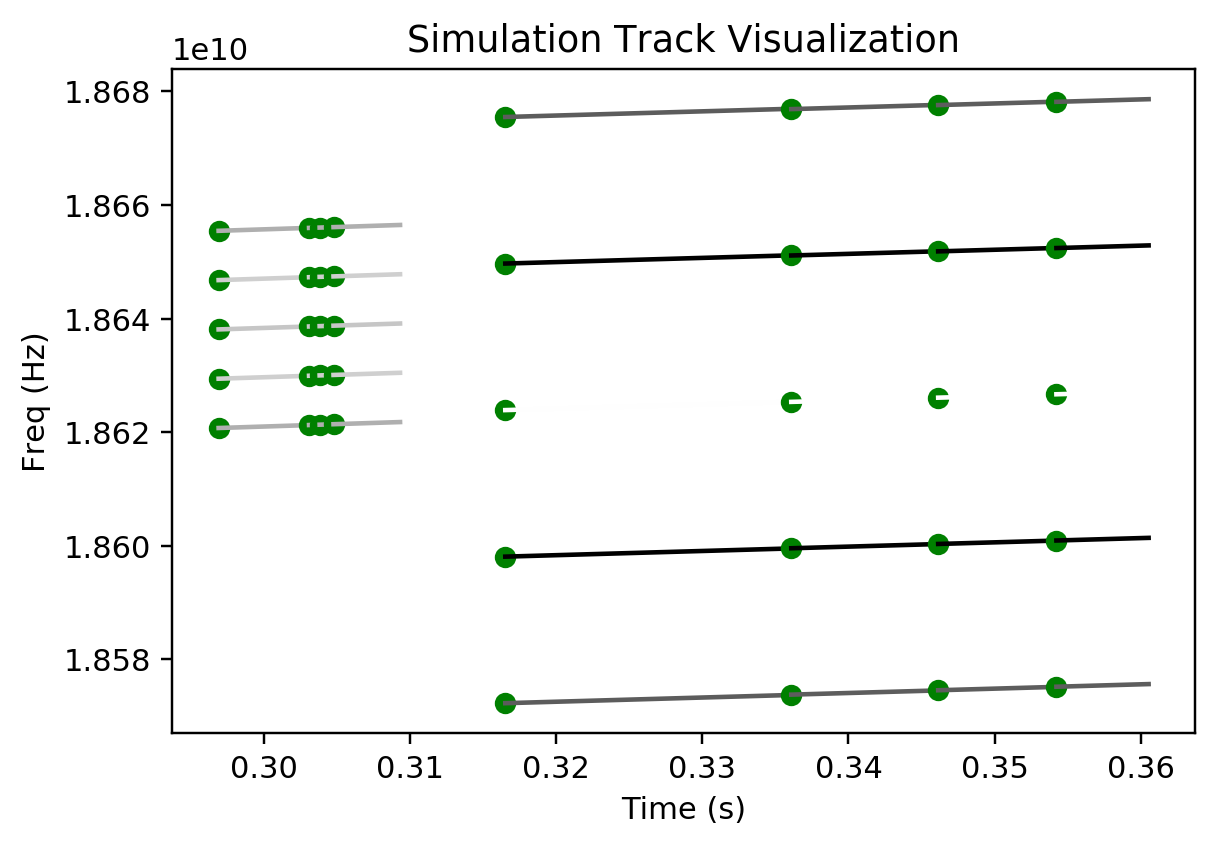

In [53]:
import he6_cres_spec_sims.analysis.visualization as viz

viz.tracks(config)